In [1]:
import env
import acquire_bootcamp_readme
import prepare_bootcamp_readme
import explore_bootcamp_readme
import model_bootcamp_readme
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Whipping the Model into Shape with Bootcamps!

## Executive Summary
1. Model had 81% overall accuracy on test sample data
    * High precision and recall for JavaScript (84%, 100%) and Jupyter Notebook (87%, 81%)
2. "Python" had the second highest TF across all README files and the highest TF-IDF
3. Still have room for improvement
    * Model struggles to identify Java repositories (0% for both precision and recall on test data)
    * Model has lower precision and recall for Python than Jupyter Notebook (65%, 73%)
    
## Planning
I wanted to create a classification model that would predict the language of coding bootcamp repositories. I planned to use the GitHub API to retrieve 1000 of the most starred repositories with "bootcamp" in their name. After my first iteration, I decided to focus on Java and JavaScript (web development languages) and Jupyter Notebook and Python (data science languages). This helped me narrow the scope of my project and improved the performance of the model. I also decided to add the `is_webdev` feature to the model which helped improve model performance further.

## Acquire and Prepare

The data was acquired using the GitHub API. The search repositories endpoint was used to generate a list of 1000 most starred repositories with "bootcamp" in the name and the get repositories endpoint was used to retrieve the contents of each repository in the list. If running for the first time, replace the `read_csv` function call with `acquire_bootcamp_read.scrape_github_data`. Since acquiring data takes a long time, I advise exporting to a CSV file after acquiring for the first time. The end result is a data frame of 998 rows with repo, language, and readme_contents columns.

In [2]:
bootcamp_readme_df = pd.read_csv(env.data_path + "coding_bootcamp_readme.csv")

To prepare the data, I simply dropped any rows that had NaN or empty values. To narrow the scope of my model, I only selected repositories with Java, JavaScript, Jupyter Notebook, or Python as the language. This left me with 451 rows. The README text of the remaining rows were cleaned (\n newline characters were also removed), tokenized, stop words were removed ("de", "e", and numbers 0-9 were added to the standard list of stopwords), and lemmatized. 

In [3]:
bootcamp_readme_df = prepare_bootcamp_readme.prepare_bootcamp_readme_df(bootcamp_readme_df)

NaN values
     rows  columns
0       4        1
1      15        1
2      17        2
3      19        1
4      23        1
..    ...      ...
269   983        1
270   987        1
271   989        1
272   990        1
273   993        1

[274 rows x 2 columns]
--------------------------------
Empty values
   rows  columns
0   514        2
1   565        2
2   635        2
--------------------------------


In [4]:
bootcamp_readme_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 451 entries, 0 to 997
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             451 non-null    object
 1   language         451 non-null    object
 2   readme_contents  451 non-null    object
dtypes: object(3)
memory usage: 14.1+ KB


## Explore

In [5]:
bootcamp_readme_df.language.value_counts()

JavaScript          184
Jupyter Notebook    157
Python               73
Java                 37
Name: language, dtype: int64

JavaScript and Jupyter Notebook dominate the results.

In [6]:
languages_df = explore_bootcamp_readme.generate_language_count_df(bootcamp_readme_df.language)

In [7]:
print(f"Combined % of web dev languages:  {round(languages_df.loc[['JavaScript', 'Java']].percent.sum(), 4)}")
print(f"Combined % of data science languages:  {round(languages_df.loc[['Jupyter Notebook', 'Python']].percent.sum(), 4)}")

Combined % of web dev languages:  0.49
Combined % of data science languages:  0.51


Almost equal split between web development language repositories (JavaScript, Java) and data science language repositories (Jupyter Notebook, Python).

In [8]:
readme_words_by_language_dict, word_count_by_language_dict = explore_bootcamp_readme.generate_word_list_and_count_dictionaries(languages_df, \
                                                                                                                               bootcamp_readme_df)

word_counts_df = explore_bootcamp_readme.generate_word_count_df(word_count_by_language_dict)

In [9]:
word_counts_df.sort_values(by='all_languages', ascending=False).head(10)

,JavaScript,Jupyter Notebook,Python,Java,all_languages
9,144,248,437,54,883
python,9,589,282,0,880
bootcamp,207,287,141,32,667
data,88,400,120,20,628
code,249,131,108,20,508
use,246,121,96,18,481
project,220,77,88,34,419
using,138,141,71,29,379
run,230,54,66,14,364
file,141,77,123,16,357


The top 10 words in README files for all languages are:  
1. 9
1. python
1. bootcamp
1. data
1. code
1. use
1. project
1. using
1. run
1. file

* I am not sure why "9" wasn't cleaned. I also don't know what its signficance is.
* "python" shows up frequently in Jupyter Notebooks, so that may cause some false negatives for Python.
* "data" seems to be a good indicator of data science repositories.
* "project" and "run" seem to be in web development repositories more.

Are there any words that identify web dev languages from data science languages?

In [10]:
data_sci_words_df = explore_bootcamp_readme.get_data_sci_words_df(word_counts_df)

# Words usually found in data science README files, but not in web dev
data_sci_words_df.index.unique()

Index(['panda', 'neural', 'x', 'w', 'analysis', 'university', 'science',
       'jupyter', 'notebook', 'python', 'variable', 'heroku', 'veri', 'track',
       'module', 'print', 'django', 'reward', 'function', 'cell',
       'computational', 'tensorflow', 'jezyku', 'visualization', 'anaconda',
       'steering', 'pycharm', 'def', 'selenium', 'deepracer', 'race', 'agent',
       'car', 'milvus', 'olarak'],
      dtype='object')

In [11]:
web_dev_words_df = explore_bootcamp_readme.get_web_dev_words_df(word_counts_df)

# Words usually found in web development README files, but not in data science
web_dev_words_df.index.unique()

Index(['junit', 'robolectric', 'odev', 'genymotion', 'cordapp', 'treasure',
       'expense', 'layout', 'checkpoint', 'android', 'altbr', 'width100px',
       'h3', 'var', 'hr', 'td', 'yarn', 'nodejs', 'id', 'npm', 'criacao',
       'intent', 'com', 'spring', 'aula', 'uma', 'desafio', 'na', 'em',
       'projeto', 'um', 'react'],
      dtype='object')

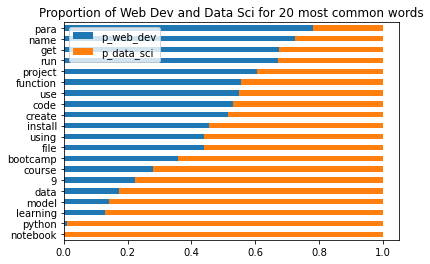

In [12]:
word_counts_df = explore_bootcamp_readme.count_words_between_webdev_datasci(word_counts_df)

explore_bootcamp_readme.plot_proportion_of_words(word_counts_df)

* "Python", "learning", "notebook", "model", and "data" were overwhelmingly in data science repositories.
* "Para", "name", "get", "run", and "project" were mostly in web development repositories.

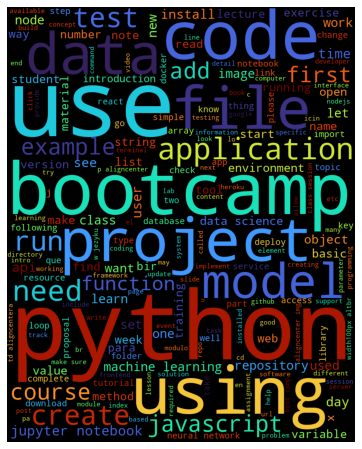

In [13]:
explore_bootcamp_readme.generate_wordcloud(readme_words_by_language_dict['all_languages'], background_color="black", colormap_value="turbo")

* "python", "bootcamp", "use", "using", and "project" stand out in the word cloud for all languages

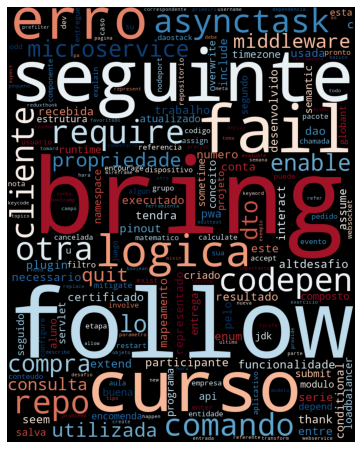

In [33]:
web_dev_word_list = \
list(set(readme_words_by_language_dict['Java'] + readme_words_by_language_dict['JavaScript']))

explore_bootcamp_readme.generate_wordcloud(web_dev_word_list, background_color="black", colormap_value="RdBu")

* "bring", "follow", "seguinte", "curso, and "fail" stand out for web dev words
    * there seem to be a lot of Spanish bootcamps

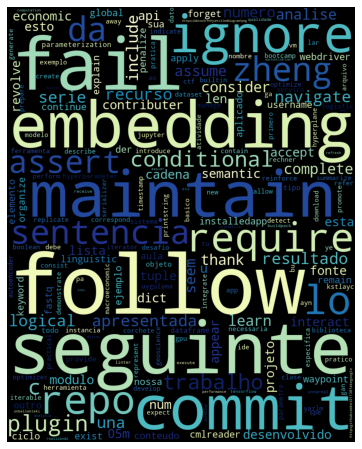

In [32]:
data_sci_word_list = list(set(readme_words_by_language_dict['Jupyter Notebook'] + readme_words_by_language_dict['Python']))

explore_bootcamp_readme.generate_wordcloud(data_sci_word_list, background_color="black", colormap_value="YlGnBu")

* "follow", "seguinte", "embedding", and "fail" stand out for data science words

## Model

I calculated the TF, IDF, and TF-IDF of each word in the README files:

In [16]:
word_list = pd.Series(readme_words_by_language_dict['all_languages'])

word_freq_df = model_bootcamp_readme.generate_tf_idf_tfidf_dataframe(word_list, bootcamp_readme_df.readme_contents)

These are the words sorted by TF:

In [17]:
word_freq_df.sort_values(by='frequency', ascending=False).head(20)

,word,raw_count,frequency,augmented_frequency,idf,tf_idf
0,9,883,0.008342,1.000000,0.958176,0.007994
1,python,880,0.008314,0.996602,1.114255,0.009264
2,bootcamp,667,0.006302,0.755379,0.163432,0.001030
3,data,628,0.005933,0.711212,0.924082,0.005483
4,code,508,0.004800,0.575311,0.952412,0.004571
5,use,481,0.004544,0.544734,0.859194,0.003905
6,project,419,0.003959,0.474519,1.162707,0.004603
7,using,379,0.003581,0.429219,1.323976,0.004741
8,run,364,0.003439,0.412231,1.259437,0.004331
9,file,357,0.003373,0.404304,1.176993,0.003970


These are the words sorted by IDF:

In [18]:
word_freq_df.sort_values(by='idf', ascending=False).head(20)

,word,raw_count,frequency,augmented_frequency,idf,tf_idf
20560,destino,1,0.000009,0.001133,6.111467,0.000058
11032,promontory,1,0.000009,0.001133,6.111467,0.000058
11018,2pic2png,1,0.000009,0.001133,6.111467,0.000058
11019,enzymesimplified,1,0.000009,0.001133,6.111467,0.000058
11020,parcalara,1,0.000009,0.001133,6.111467,0.000058
11021,repohttpsgithubcomnathinhaigtifullstackbootcam...,1,0.000009,0.001133,6.111467,0.000058
11022,httplocalhost8888tokenyourlogintoken,1,0.000009,0.001133,6.111467,0.000058
11023,01eth,1,0.000009,0.001133,6.111467,0.000058
11024,programhttpswwwudacitycomcoursedeeplearningnan...,1,0.000009,0.001133,6.111467,0.000058
11025,gerceklestirilir,1,0.000009,0.001133,6.111467,0.000058


These are the words sorted by TF-IDF:

In [19]:
word_freq_df.sort_values(by='tf_idf', ascending=False).head(20)

,word,raw_count,frequency,augmented_frequency,idf,tf_idf
1,python,880,0.008314,0.996602,1.114255,0.009264
0,9,883,0.008342,1.000000,0.958176,0.007994
14,model,301,0.002844,0.340883,1.937080,0.005509
3,data,628,0.005933,0.711212,0.924082,0.005483
16,notebook,286,0.002702,0.323896,1.834801,0.004958
23,javascript,272,0.002570,0.308041,1.921813,0.004939
15,function,288,0.002721,0.326161,1.807402,0.004918
7,using,379,0.003581,0.429219,1.323976,0.004741
6,project,419,0.003959,0.474519,1.162707,0.004603
4,code,508,0.004800,0.575311,0.952412,0.004571


I first needed to vectorize the contents of all the README files:

In [20]:
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(bootcamp_readme_df.readme_contents)
y = bootcamp_readme_df.language

Then I added the 'is_webdev' feature with my `add_features` function:

In [21]:
X = model_bootcamp_readme.add_features(X, tfidf, bootcamp_readme_df)

The entire population was split into train, validate, and test samples. For modeling, those samples were divided even further into feature (X) and label (y) splits.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=1414)

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, stratify=y_train, test_size=.3, random_state=1414)

In [23]:
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

The model was trained using the features and labels from the training sample:

In [24]:
lm = LogisticRegression(class_weight="balanced").fit(X_train, y_train)

I used the model to predict the repository language and appended the prediction to the train, validate, and test data frames.

In [25]:
train['predicted'] = lm.predict(X_train)
validate['predicted'] = lm.predict(X_validate)
test['predicted'] = lm.predict(X_test)

The training sample results are overfit since the overall accuracy is 100% with 100% precision and 100% recall for all languages.

In [26]:
model_bootcamp_readme.print_model_evaluation(train)

Accuracy: 100.00%
---
Confusion Matrix
actual            Java  JavaScript  Jupyter Notebook  Python
predicted                                                   
Java                21           0                 0       0
JavaScript           0         103                 0       0
Jupyter Notebook     0           0                87       0
Python               0           0                 0      41
---
                  precision    recall  f1-score   support

            Java       1.00      1.00      1.00        21
      JavaScript       1.00      1.00      1.00       103
Jupyter Notebook       1.00      1.00      1.00        87
          Python       1.00      1.00      1.00        41

        accuracy                           1.00       252
       macro avg       1.00      1.00      1.00       252
    weighted avg       1.00      1.00      1.00       252



However, model performance remained high on the validate sample with an overall accuracy of 80%. However, precision for Python was only 55% and recall for Java was only 22%. The recall and precision for all other languages ranged from 71-86%.

In [27]:
model_bootcamp_readme.print_model_evaluation(validate)

Accuracy: 79.63%
---
Confusion Matrix
actual            Java  JavaScript  Jupyter Notebook  Python
predicted                                                   
Java                 2           0                 0       0
JavaScript           7          44                 0       0
Jupyter Notebook     0           0                28       5
Python               0           0                10      12
---
                  precision    recall  f1-score   support

            Java       1.00      0.22      0.36         9
      JavaScript       0.86      1.00      0.93        44
Jupyter Notebook       0.85      0.74      0.79        38
          Python       0.55      0.71      0.62        17

        accuracy                           0.80       108
       macro avg       0.81      0.67      0.67       108
    weighted avg       0.82      0.80      0.78       108



The overall accuracy on the test sample was 81%. Java precision and recall dropped to 0% though. The model excels at predicting JavaScript and Jupyter Notebook repositories, but seems to have trouble differentiating Python from Jupyter Notebook since the Python precision was 65% and recall was 73%.

In [28]:
model_bootcamp_readme.print_model_evaluation(test)

Accuracy: 81.32%
---
Confusion Matrix
actual            Java  JavaScript  Jupyter Notebook  Python
predicted                                                   
JavaScript           7          37                 0       0
Jupyter Notebook     0           0                26       4
Python               0           0                 6      11
---
                  precision    recall  f1-score   support

            Java       0.00      0.00      0.00         7
      JavaScript       0.84      1.00      0.91        37
Jupyter Notebook       0.87      0.81      0.84        32
          Python       0.65      0.73      0.69        15

        accuracy                           0.81        91
       macro avg       0.59      0.64      0.61        91
    weighted avg       0.75      0.81      0.78        91



I used my `predict_language_from_readme` function on the README text from my utilities repository and the model correctly predicted Python. This was somewhat surprising since the model struggled to differentiate Python from Jupyter Notebook.

In [29]:
readme_txt = """
# utilities
## Repository containing utilities for data science program

## How to use this repo

### Choose whether you want a stable release or the most current features:
* Stable
    1. Download the release you wish to use.
    2. Unzip to the project directory where you will be using `utilities.py`
* Current (Recommended)
    1. Clone this repository
    2. If you do not have your own `env.py`:
        1. Remove ".template" from the `env.py.template` file
        2. Set up your `env.py` with the correct settings for your environment
    3. If you have an `env.py`, add the following to your file:
        * `import sys`
        * `sys.path.append("/path/to/utilities")`
            * Replace "/path/to/utilities" with the absolute path to the repository
* Import to your notebook or module using:  `import utilities` or `from utilities import...`
"""

model_bootcamp_readme.predict_language_from_readme(lm, tfidf, readme_txt, False)

array(['Python'], dtype=object)

## Delivery

### Conclusions
1. Highly accurate model (81% overall) with excellent precision and recall for JavaScript and Jupyter Notebook.
1. Unsurprisingly, "python" is a keyword for classifying repositories since its TF and TF-IDF values rank the highest
1. Need to improve performance on classifying Java and Python repositories

### Recommendations
1. Add more Java and Python observations to better train the model on discerning those repositories from JavaScript and Jupyter Notebook
    * Preferably enough to have equal representation of all languages
1. Split the model between data science and web development languages
    * Remove the need to add `is_webdev` feature